## Authors

Daniel Alpizar, Gabriel Abes, Jocelyn Oja, Khalil Nayef

## Introduction

In this Notebook we will be looking at machine learning methods for carpal tunnel severity (CTS) classification. The outcome of this notebook is intended to examine how machine learning models compare with regard to classifying severity of CTS. CTS can be a debilitating condition, especially in jobs that often require many hours of repetitive movements. Our group found that not many models on CTS Severity Classification currently exist, which led us to formulate our guiding question: "Can Machine Learning Models classify the severity of CTS accurately based on clinical data?"

## Dataset and Methods

The Carpal Tunnel Severity dataset we are using is from the National Centre for Biotechnology Information, and it was conducted on 1037 patients between January 2015 and February 2021. The study was reviewed and approved by the Institutional Review Board of Pohang Stroke and Spine Hospital.

The features in this dataset include:
* Age
* Sex
* Body-Mass Index (BMI)
* Right Side Involvement (binary)
* Diabetes (binary)
* Duration of Symptoms (in months)
* Numeric Rating Scale of Pain (NRS)
* Nocturnal Pain (binary)
* Thenar Weakness and/or Atrophy (binary)
* Cross-Sectional Area (CSA)
* Palmar Bowing (PB) of Flexor Retinaculum

We will be developing the following models:
* Logistic Regression,
* K-Nearest Neighbour Classification
* Random Forest
* Support Vector Machine
* eXtreme Gradient Boosting
* Stochastic Gradient Boosting
* Neural Network


In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, make_scorer, recall_score, f1_score, precision_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import cycle

# Tensorflow libraries
import tensorflow as tf
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Precision, Recall


Preparing the data


In [ ]:
# Load the dataset
url_data = 'https://raw.githubusercontent.com/daniel-alpizar/carpal_tunnel_classification/main/41598_2021_97043_MOESM2_ESM.csv'
data = pd.read_csv(url_data)
data = data.drop(columns=["Mild", "Mod", "Sev"])
display(data.head(3))
data.info()

,Severity,Age,BMI,CSA,PB,Duration,NRS,Sex,Side,Diabetes,NP,Weakness
0,mild,65,21.093750,10.0,1.9,3,2,1,1,0,0,0
1,severe,68,20.415225,13.0,1.8,12,6,0,0,0,0,0
2,mild,68,20.415225,13.0,1.5,12,3,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Severity  1037 non-null   object 
 1   Age       1037 non-null   int64  
 2   BMI       1037 non-null   float64
 3   CSA       1037 non-null   float64
 4   PB        1037 non-null   float64
 5   Duration  1037 non-null   int64  
 6   NRS       1037 non-null   int64  
 7   Sex       1037 non-null   int64  
 8   Side      1037 non-null   int64  
 9   Diabetes  1037 non-null   int64  
 10  NP        1037 non-null   int64  
 11  Weakness  1037 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 97.3+ KB


In [ ]:
unique_classes = data['Severity'].unique()
print(unique_classes)

['mild' 'severe' 'moderate']


In [ ]:
# Check dataset size
data.shape

(1037, 12)

In [ ]:
# Summarize data with basic statistics
display(data.describe().round(2))

,Age,BMI,CSA,PB,Duration,NRS,Sex,Side,Diabetes,NP,Weakness
count,1037.00,1037.00,1037.00,1037.00,1037.00,1037.00,1037.00,1037.00,1037.00,1037.00,1037.00
mean,57.95,24.76,15.15,2.47,8.27,4.40,0.61,0.49,0.14,0.44,0.19
std,10.82,3.42,4.30,1.83,9.59,1.84,0.49,0.50,0.35,0.50,0.39
min,19.00,17.63,7.00,0.21,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,51.00,22.43,12.00,1.70,2.00,3.00,0.00,0.00,0.00,0.00,0.00
50%,58.00,24.34,14.00,2.20,5.00,4.00,1.00,0.00,0.00,0.00,0.00
75%,65.00,26.73,17.00,2.90,12.00,5.00,1.00,1.00,0.00,1.00,0.00
max,87.00,42.60,37.00,40.00,60.00,10.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
categorical_cols = ['Severity', 'Sex', 'Side', 'Diabetes', 'NP', 'Weakness']
data[categorical_cols] = data[categorical_cols].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Severity  1037 non-null   category
 1   Age       1037 non-null   int64   
 2   BMI       1037 non-null   float64 
 3   CSA       1037 non-null   float64 
 4   PB        1037 non-null   float64 
 5   Duration  1037 non-null   int64   
 6   NRS       1037 non-null   int64   
 7   Sex       1037 non-null   category
 8   Side      1037 non-null   category
 9   Diabetes  1037 non-null   category
 10  NP        1037 non-null   category
 11  Weakness  1037 non-null   category
dtypes: category(6), float64(3), int64(3)
memory usage: 55.5 KB


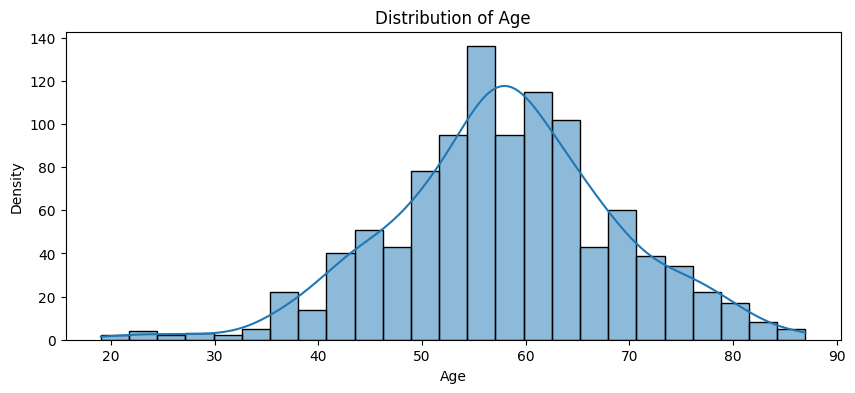

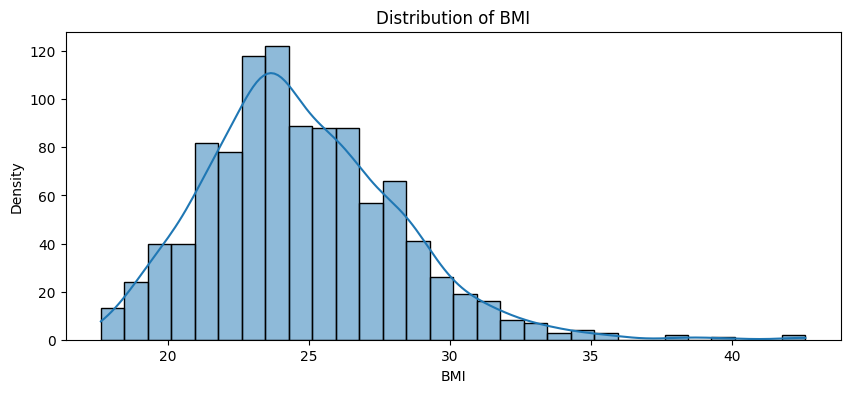

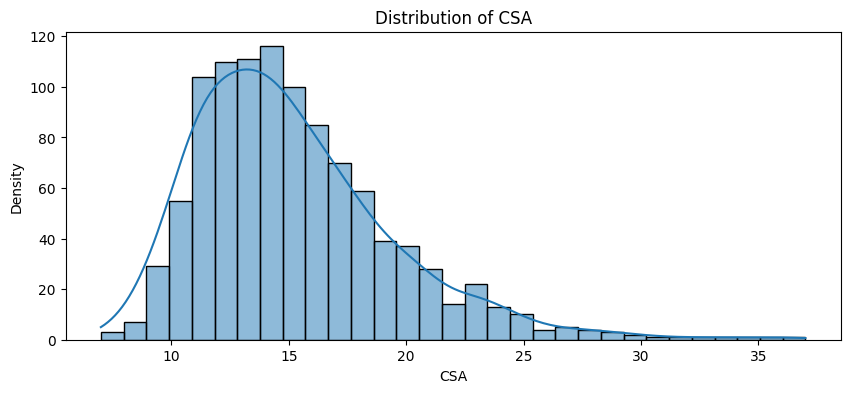

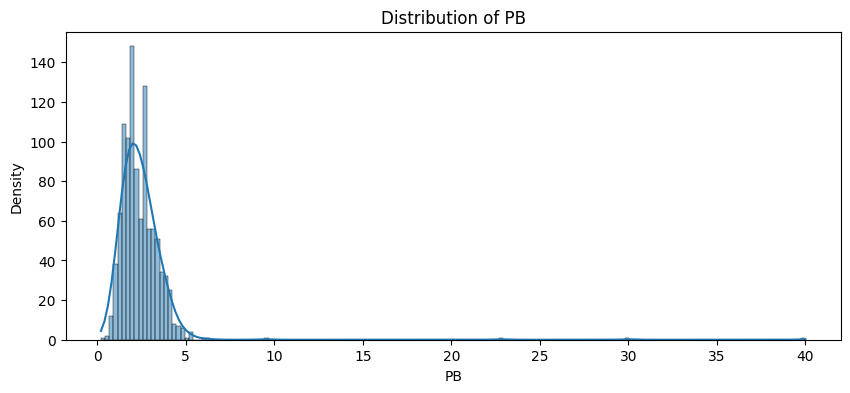

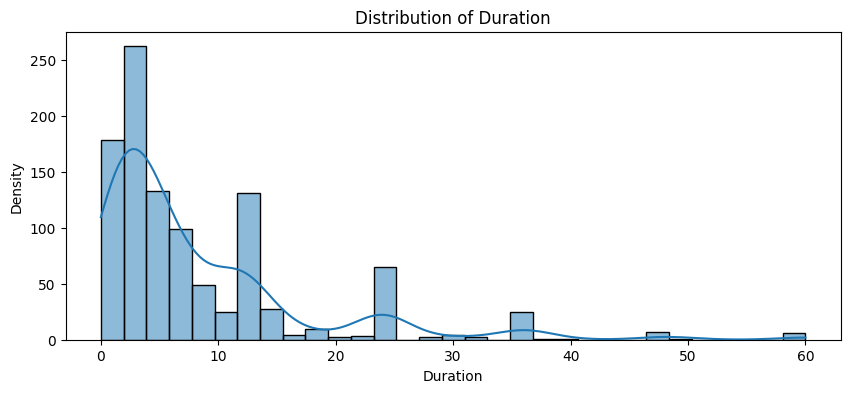

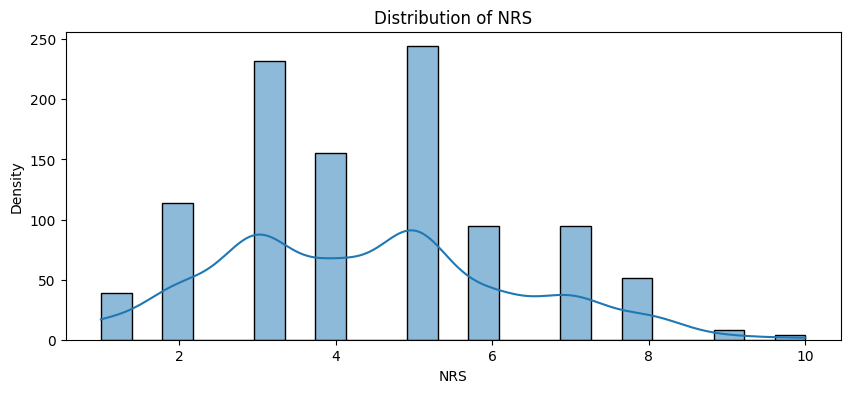

In [ ]:
# Select numeric features only
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns

# Plot distribution for each numeric feature
for column in numeric_features:
    plt.figure(figsize=(10, 4))  # Set figure size
    sns.histplot(data[column], kde=True)  # Use histplot with a kernel density estimate (KDE)
    plt.title(f'Distribution of {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Density')  # Set y-axis label
    plt.show()


The distribution plots above show that Age and BMI, and CSA seem to have relatively normal distributions, but Duration and PB have long tails, suggesting they are right-skewed. NRS has a relatively normal distribution, however the two slight peaks may suggest it is a bimodal distribution.

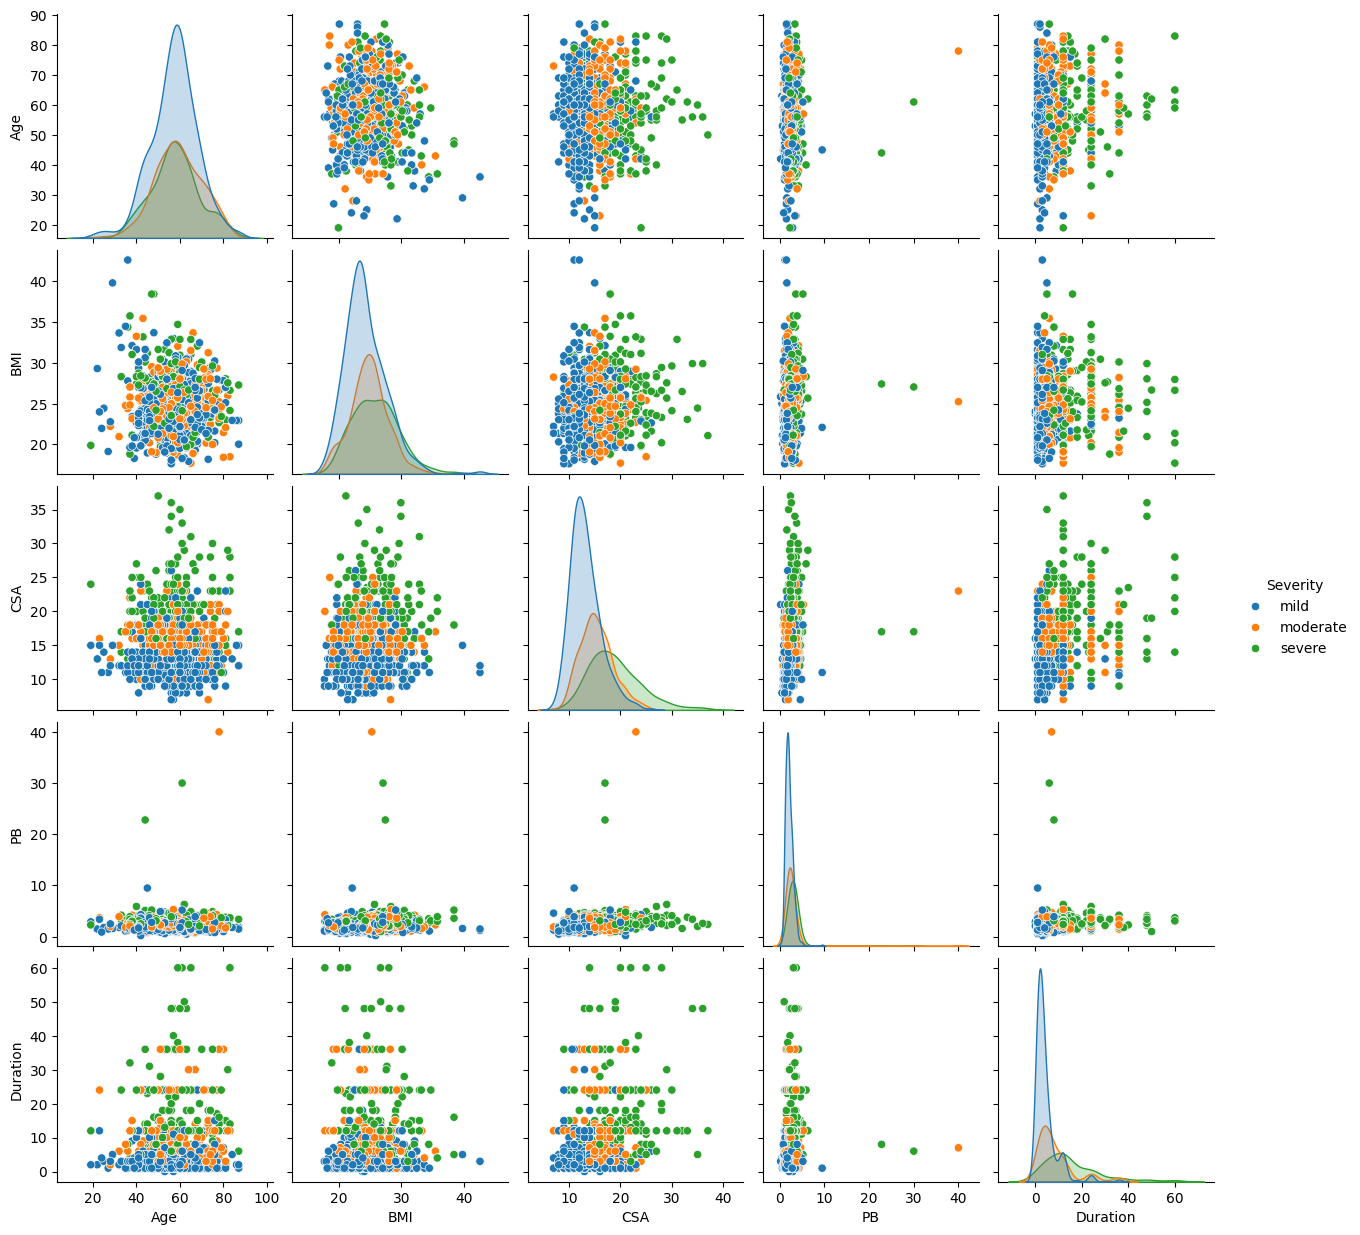

In [ ]:
sns.pairplot(data, hue='Severity',vars=['Age',	'BMI',	'CSA',	'PB',	'Duration'])

From the pairwise plots above, there are a few things to note with regards to moving further with model building. First, is that there does seem to be some outliers, especially visible in the Duration and PB plots, which might affect model performance. We also see from the distribution plots on the diagonal that the variables have different scales so standardization or normalization will be needed before modeling, especially for algorithms sensitive to feature scales. One thing also to note is that there doesn't seem to be high redundancy between features, as no pair of features shows a strong linear correlation.

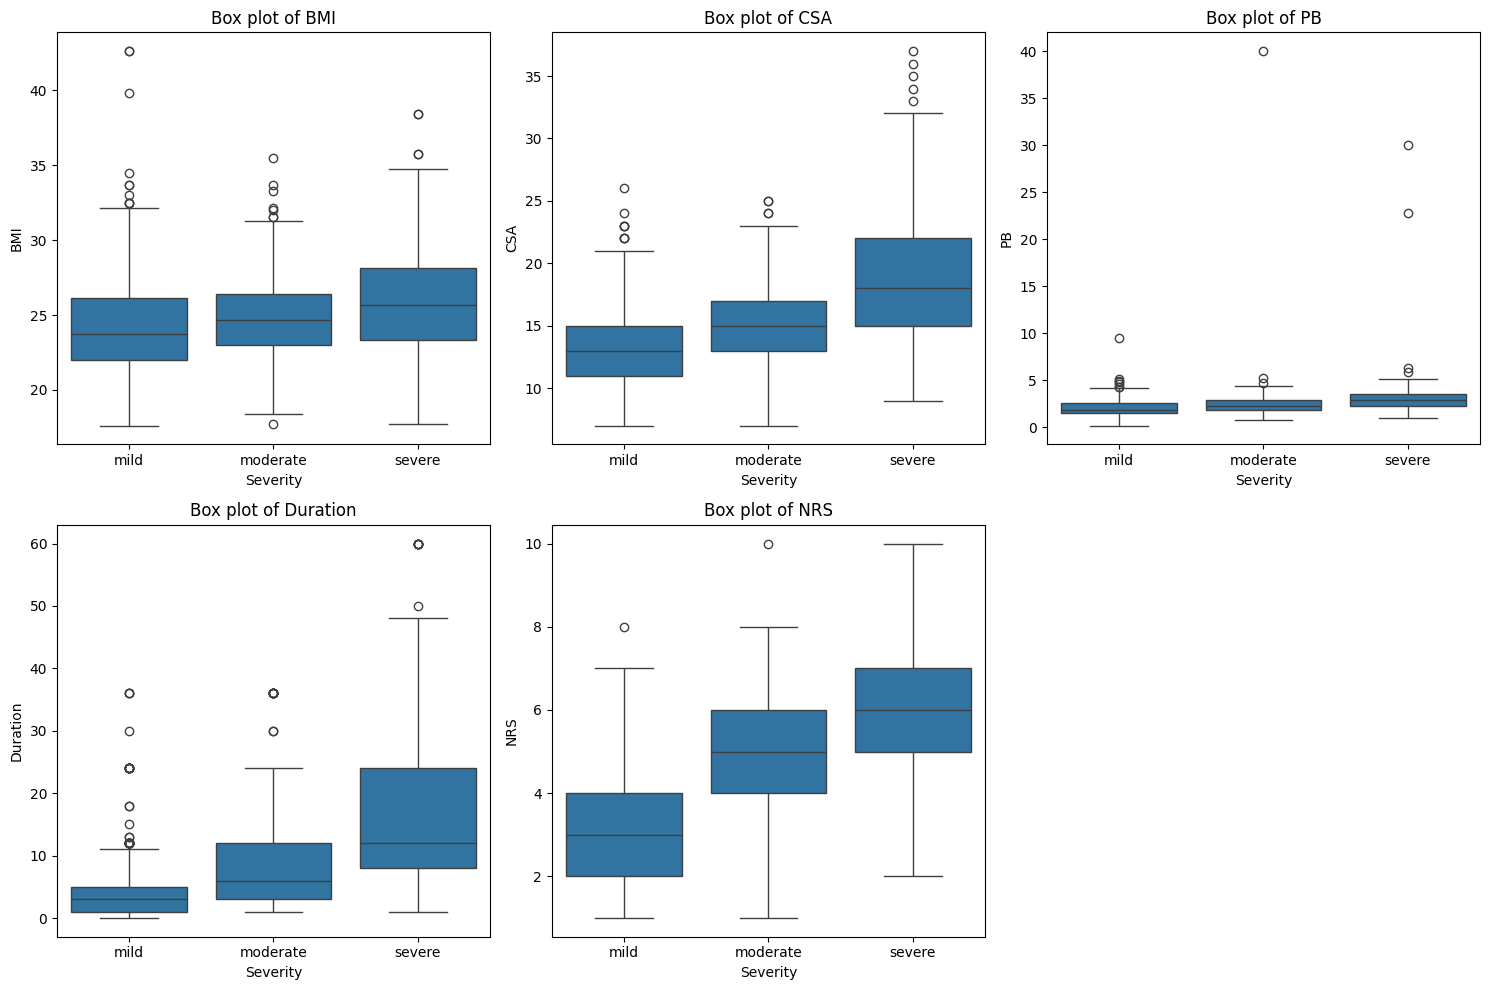

In [ ]:
# List of features to plot
features = ['BMI', 'CSA', 'PB', 'Duration', 'NRS']

# Plotting the box plots
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Severity', y=feature, data=data)
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
def num_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    upper_outer_fence = q3 + 3 * IQR
    outlier_array_indexes = np.where(df[col] > upper_outer_fence)[0]
    return outlier_array_indexes.shape[0]

# Apply the function to the dataframe and print the number of outliers for each feature
outliers_count = {}
for feature in features:
    outliers_count[feature] = num_outliers(data, feature)

outliers_count

{'BMI': 3, 'CSA': 5, 'PB': 4, 'Duration': 14, 'NRS': 0}

There does not seem to be too many outliers in the data. However, while they can affect the performance of our models, we do not have enough domain knowledge to remove the outliers without imposing undue bias. Thus, we will leave in the outliers keeping in mind how they may impact the performance of our models.

In [ ]:
# Percentage of each unique value in the 'Severity' column
percentage = data['Severity'].value_counts(normalize=True) * 100
print(percentage)

Severity
mild        48.891032
moderate    26.615236
severe      24.493732
Name: proportion, dtype: float64


In [ ]:
for feature in numeric_features:
    # Calculate the range (scale) of the feature
    feature_range = data[feature].max() - data[feature].min()

    # Calculate the variance of the feature
    feature_variance = data[feature].var()

    # Prine feature name, range, and variance
    print(f"Feature: {feature}, Range: {feature_range}, Variance: {feature_variance}")

# Getting numeric features from the dataframe
numeric_features = data.select_dtypes(include=[np.number]).columns

zero_variance_features = []

for feature in numeric_features:
    # Calculate the variance of the feature
    feature_variance = data[feature].var()

    # Check if the variance is 0 and print the feature name if it is
    if feature_variance == 0:
        zero_variance_features.append(feature)

# Output whether there are features with zero variance
zero_variance_check = "No features with zero variance." if not zero_variance_features else zero_variance_features

zero_variance_check

Feature: Age, Range: 68, Variance: 117.10665231976708
Feature: BMI, Range: 24.965423940000004, Variance: 11.67385106146239
Feature: CSA, Range: 30.0, Variance: 18.531281056507666
Feature: PB, Range: 39.79, Variance: 3.3400637728374463
Feature: Duration, Range: 60, Variance: 91.96203966743987
Feature: NRS, Range: 9, Variance: 3.3937237278606616


'No features with zero variance.'

We note that no features have a non-zero variance, meaning we will keep all features in when building our models as they all have potential for predictive ability.

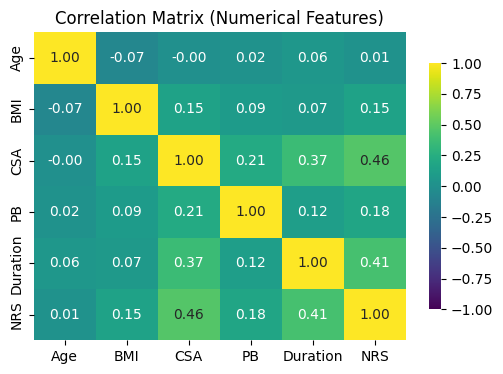

In [ ]:
# Compute the correlation matrix using Pearson's correlation coefficient
df_numerical = data.drop(categorical_cols, axis=1)
correlation_matrix = df_numerical.corr()

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

Most variables have low to moderate correlations with each other, indicating that there are no redundant features in the dataset. Notably, the Numeric Rating Scale of Pain (NRS) shows a moderate positive correlation with Cross-Sectional Area (CSA) at 0.46, suggesting that as CSA increases, there is a tendency for the NRS score to increase as well. Similarly, there is a moderate correlation between CSA and Duration of Symptoms at 0.37, indicating a potential relationship where longer symptom duration might be associated with larger CSA. BMI has a very low correlation with all other features, suggesting it does not share a strong linear relationship with them in this dataset. Overall, the matrix indicates that while there are some relationships, each feature provides unique information and thus can contribute independently to any analysis involving these variables.

In [ ]:
# Calculate VIF for each numeric feature

numeric_data = data.select_dtypes(include=['int64', 'float64'])
numeric_data_with_const = pd.concat([pd.Series(1, index=numeric_data.index, name='const'), numeric_data], axis=1)

# Initialize DataFrame to store VIF values
VIF_data = pd.DataFrame()
VIF_data["feature"] = numeric_data_with_const.columns

# Calculate VIF for each feature
VIF_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]

# Drop the entry for the constant
VIF_data = VIF_data[VIF_data['feature'] != 'const']

VIF_data

,feature,VIF
1,Age,1.009529
2,BMI,1.041189
3,CSA,1.376112
4,PB,1.058917
5,Duration,1.266293
6,NRS,1.413792


The Variance Inflation Factor (VIF) test results shown indicate that multicollinearity is not a significant concern for the dataset's numerical features. Here, all VIF values are well below the 5 threshold, which could suggest that multicollinearity may be inflating the variance of the estimated regression coefficients, making them less reliable. On the contrary, the results suggest that each feature can be considered fairly independent in regression models.

## Pre-processing

In [ ]:
# Label encoding the target variable
le = LabelEncoder()
severity_encoded = le.fit_transform(data['Severity'])


# Specifying columns for encoding categorical features and scaling numerical features
columns_to_encode = ['Sex', 'Side', 'Diabetes', 'NP', 'Weakness']
columns_to_scale  = data.columns.difference(categorical_cols)

# Creating a ColumnTransformer to encode and scale variables for model training
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale),
        ('cat', OneHotEncoder(), columns_to_encode)
    ])

## Splitting the Data

In [ ]:
# Using the LabelEncoder to encode the 'Severity' column from the dataset
le = LabelEncoder()
severity_encoded = le.fit_transform(data['Severity'])

# Printing the unique classes and their corresponding numerical labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'mild': 0, 'moderate': 1, 'severe': 2}

In [ ]:
# Setting 'Severity' as the target variable and remaining columns as features
X = data.drop('Severity', axis=1)
y = severity_encoded

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Logistic Regression

We considered using Logistic Regression as a parameteric method to approach. In the following section we compared logistic regression without penalty and adding L1 and L2 regularization to prevent overfitting and or potentially simplify the model.

In [ ]:
logistic_no_penalty = LogisticRegression(penalty=None, solver='lbfgs', max_iter=20000, random_state=42)
pipeline_no_penalty = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_no_penalty)
])

# Fit the pipeline to the training data
pipeline_no_penalty.fit(X_train, y_train)

# Predict using the pipeline on the test data
y_pred_no_penalty = pipeline_no_penalty.predict(X_test)

accuracy_no_penalty = accuracy_score(y_test, y_pred_no_penalty)
print(f"Accuracy on test data: {accuracy_no_penalty*100:.3f}%")


Accuracy on test data: 73.397%


Now let us optimize Logistic Regression with cross-validation with L1 and L2 regularization.

In [ ]:
# Initialize the logistic regression model with a higher number of iterations
logreg = LogisticRegression(solver='saga', max_iter=500000, random_state=42)

# Parameter Grid
param_grid = {
    'classifier__C': np.logspace(-6, 6, 100),
    'classifier__penalty': ['l1', 'l2', None]  # Assuming 'none' is valid in your scikit-learn version
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

# Initialize and fit the Grid Search model
grid_search_LR = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search_LR.fit(X_train, y_train)
best_params_LR = grid_search_LR.best_params_
print(f"Best parameters: {best_params_LR}")


optimized_LR = LogisticRegression(
    **{k.replace('classifier__', ''): v for k, v in best_params_LR.items()},
    solver='saga',
    max_iter=500000,
    random_state=42
)
optimized_LR.fit(X_train, y_train)

# Predict on the test data and evaluate
y_test_LR = optimized_LR.predict(X_test)
accuracy = accuracy_score(y_test, y_test_LR)
print(f"Accuracy on test data: {accuracy*100:.3f}%")



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'classifier__C': 0.16297508346206435, 'classifier__penalty': 'l1'}
Accuracy on test data: 73.077%


It seems that the L1 regularization has the best performance with a slightly lower accuracy. However, let us examine if there are any features that can be removed using the optimal C.

Accuracy on test data: 73.077%
Features with coefficient of 0: ['Sex']


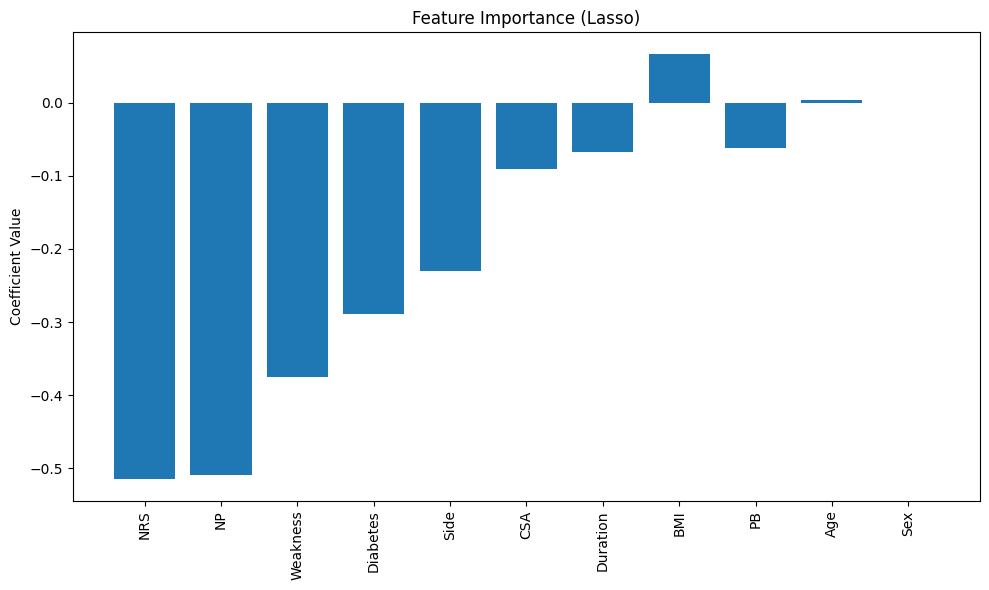

In [ ]:
# After completing the grid search
best_C = grid_search_LR.best_params_['classifier__C']


optimized_lasso = LogisticRegression(
    penalty='l1',
    C=best_C,  # Use the best C value obtained from GridSearchCV
    solver='saga',
    max_iter=500000,
    multi_class='multinomial',
    random_state=42
)

# Proceed to fit, predict, and plot
optimized_lasso.fit(X_train, y_train)

# Extracting the coefficients for plotting
coefs = optimized_lasso.coef_[0]


# Predict on the test data
y_test_pred = optimized_lasso.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test data: {accuracy*100:.3f}%")


feature_names = list(X_train.columns)


# Identifying features with zero coefficients
zero_coef_features = [feature_names[i] for i, coef in enumerate(coefs) if coef == 0]

print("Features with coefficient of 0:", zero_coef_features)


# Plotting the feature importance
plt.figure(figsize=(10, 6))
indices = np.argsort(np.abs(coefs))[::-1]  # Sort features by importance
plt.bar(np.array(feature_names)[indices], coefs[indices])
plt.xticks(rotation=90)
plt.ylabel('Coefficient Value')
plt.title('Feature Importance (Lasso)')
plt.tight_layout()
plt.show()

It seems that Lasso is removing sex as feature with the optimal C. The most important features being the NRS, NP, Weakness, and Diabetes. We will compare this model to other non-parameteric models later on. Notably, for simpler models, removing the sex feature will yield efficient results when developing logistic regression models.

In [ ]:
# Compute metrics for L1 model
accuracy_l1 = accuracy_score(y_test, y_test_pred)
precision_l1, recall_l1, f1_l1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted', zero_division=0)


# Combine all metrics into a single DataFrame for easy comparison
l1_metrics_df = pd.DataFrame({
    "Classifier": ["L1 Logistic Regression"],
    "Accuracy": [accuracy_l1],
    "Precision": [precision_l1],
    "Recall": [recall_l1],
    "F1 Score": [f1_l1]
})
l1_metrics_df



,Classifier,Accuracy,Precision,Recall,F1 Score
0,L1 Logistic Regression,0.730769,0.725818,0.730769,0.722968


Based on the L1 logistic regression with an optimal C, the model has an accuracy of 0.730769, with a precision of 0.725818, a recall of 0.730769, and an F1 score of 0.722968. Let us use a one-vs-rest evaluation to examine the model's performance on classifying each class.

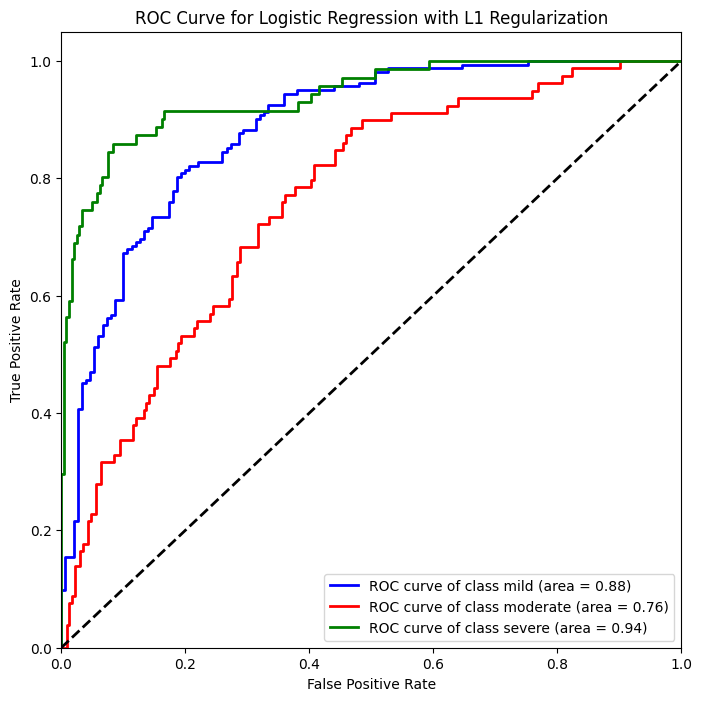

In [ ]:
# Binarize the output/labels for multiclass
y_bin = label_binarize(y_test, classes=np.unique(y_train))

# Predict class probabilities
y_pred_prob_l1 = optimized_lasso.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_bin.shape[1]
fpr_l1 = dict()
tpr_l1 = dict()
roc_auc_l1 = dict()

for i in range(n_classes):
    fpr_l1[i], tpr_l1[i], _ = roc_curve(y_bin[:, i], y_pred_prob_l1[:, i])
    roc_auc_l1[i] = auc(fpr_l1[i], tpr_l1[i])

# mapping index to class labels
class_labels = ['mild', 'moderate', 'severe']

# Plot ROC curves
plt.figure(figsize=(8, 8))

colors = ['blue', 'red', 'green']  # Colors for each class/line
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_l1[i], tpr_l1[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc_l1[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with L1 Regularization')
plt.legend(loc="lower right")
plt.show()

The mild class has an AUC of 0.88, which is relatively high. The moderate class is the lowest at 0.76, which means the model struggles to classify this class the most. Severe is the highest at 0.94, which is a bit better than the mild class.

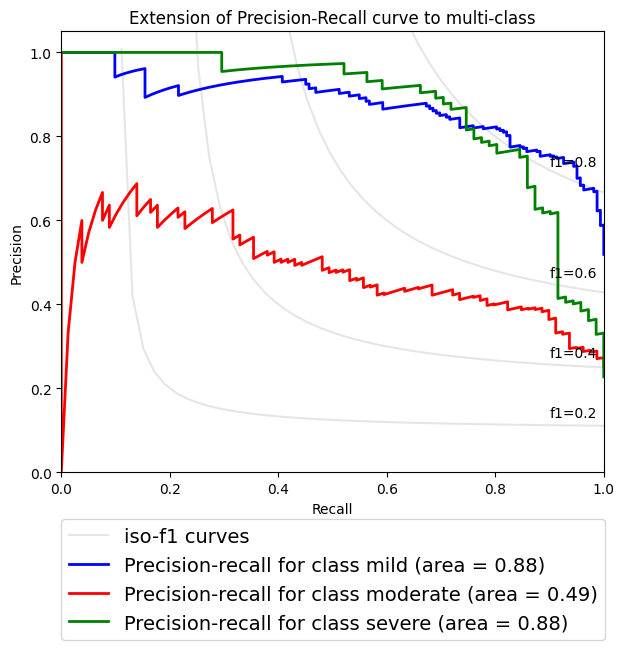

In [ ]:
# Binarize the output/labels for multiclass
y_bin = label_binarize(y_test, classes=np.unique(y_train))

# Predict class probabilities
y_pred_prob_l1 = optimized_lasso.predict_proba(X_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_bin.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_pred_prob_l1[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_pred_prob_l1[:, i])

# Setup plot details
colors = ['blue', 'red', 'green']

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

# Plot the Precision-Recall curve for each class
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'.format(class_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()

Both the severe and mild classes have the same AUPRC which indicates a high precision and recall at 0.88. However, the moderate class is fairly low, at 0.49. Thus, there may be more performant models that can better classify the moderate class.

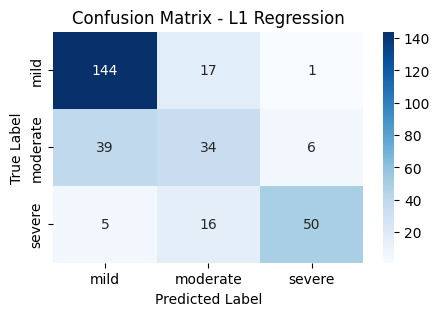

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_labels = ['mild', 'moderate', 'severe']

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - L1 Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

We can see that the confusion matrix reflects the same results from the previous plots. Most of the mild cases are correctly classified at 144 true positives 34 were correctly classified as moderate, and 50 were correctly labeled as severe.

## K-Nearest Neighbors (KNN)

Best number of neighbors: 25 with Cross-Validated Accuracy: 0.7324


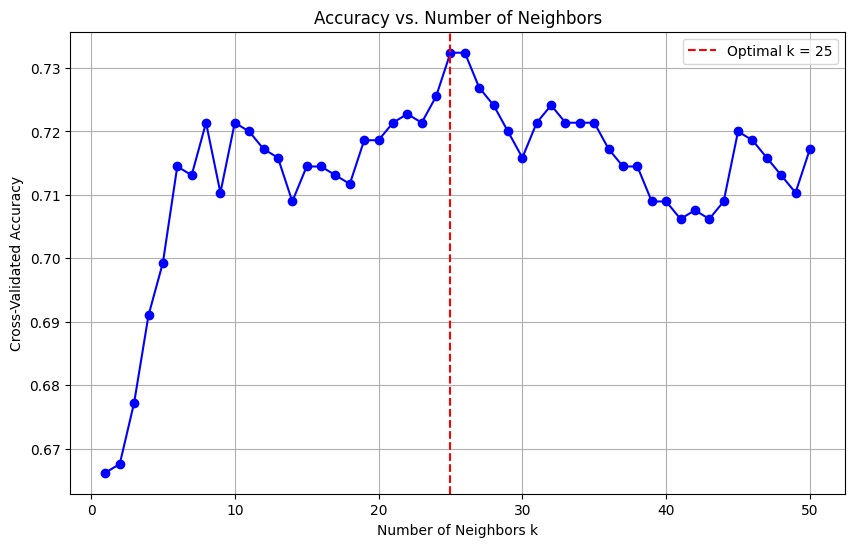

In [ ]:
from sklearn.model_selection import cross_val_score

# Defining the range of 'k' values to explore
k_range = range(1, 51)
accuracy_scores = []

# Perform cross-validation for each 'k' and store the mean accuracy
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Incorporate scaling in the cross-validation process
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', knn)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())

# Find the 'k' value with the highest mean accuracy
best_k = accuracy_scores.index(max(accuracy_scores)) + 1
print(f"Best number of neighbors: {best_k} with Cross-Validated Accuracy: {max(accuracy_scores):,.4f}")

# Plotting the accuracy scores for different 'k' values
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracy_scores, marker='o', linestyle='-', color='blue')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k = {best_k}')
plt.legend()
plt.show()


We will use 25 k-neighbours. This number of k-neighbours outputted an accuracy of 0.7324 on the training set.

In [ ]:
optimal_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
pipeline_optimal_knn = Pipeline([
    (('preprocessor', preprocessor)),
    ('knn', optimal_knn_classifier)
])

# Fit the pipeline on the training data and predict on the test set
pipeline_optimal_knn.fit(X_train, y_train)
test_pred_knn = pipeline_optimal_knn.predict(X_test)


In [ ]:
# Compute the metrics
accuracy_knn = accuracy_score(y_test, test_pred_knn)
precision_knn, recall_knn, f1_knn, _ = precision_recall_fscore_support(y_test, test_pred_knn, average='weighted')
# Creating a DataFrame to display the metrics for the KNN Classifier
knn_metrics_df = pd.DataFrame({
    "Classifier": ["KNN Classifier"],
    "Accuracy": [accuracy_knn],
    "Precision": [precision_knn],
    "Recall": [recall_knn],
    "F1 Score": [f1_knn]
})

knn_metrics_df

,Classifier,Accuracy,Precision,Recall,F1 Score
0,KNN Classifier,0.730769,0.720605,0.730769,0.717266


We see that the accuracy is similar to Logistic Regression with L1 regularization at 0.730769, but its precision is slightly lower at 0.720605, similar recall at 0.730769, but a lower F1 score of 0.717269.

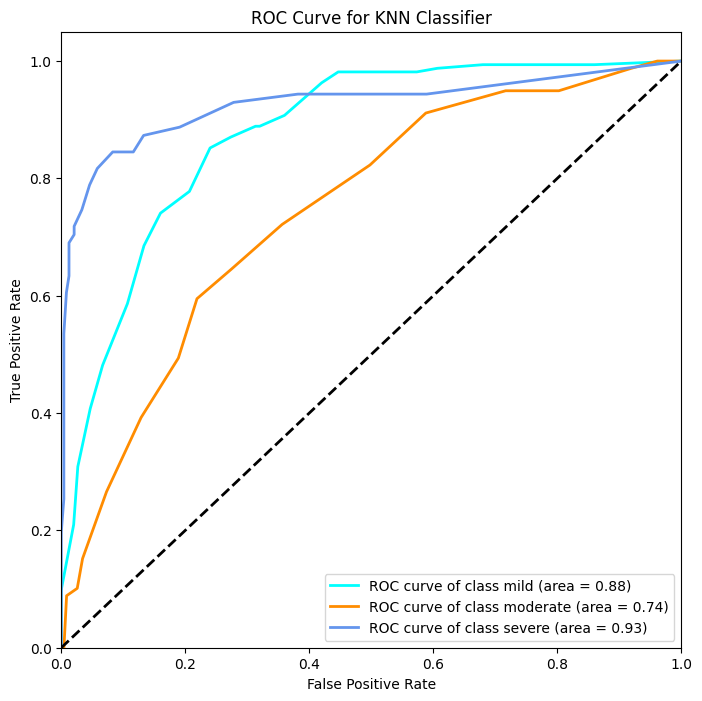

In [ ]:
# Binarize the output/labels for multiclass
y_bin = label_binarize(y_test, classes=np.unique(y_train))

# Predict class probabilities
y_pred_prob_knn = pipeline_optimal_knn.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
n_classes = y_bin.shape[1]

class_labels = ['mild', 'moderate', 'severe']

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_bin[:, i], y_pred_prob_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_knn[i], tpr_knn[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc_knn[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier')
plt.legend(loc="lower right")
plt.show()

We see the ROC curves being similar to L1 Logistic Regression but with similar mild AUC at 0.88, slightly lower for moderate at 0.74, and slightly lower for severe at 0.93.

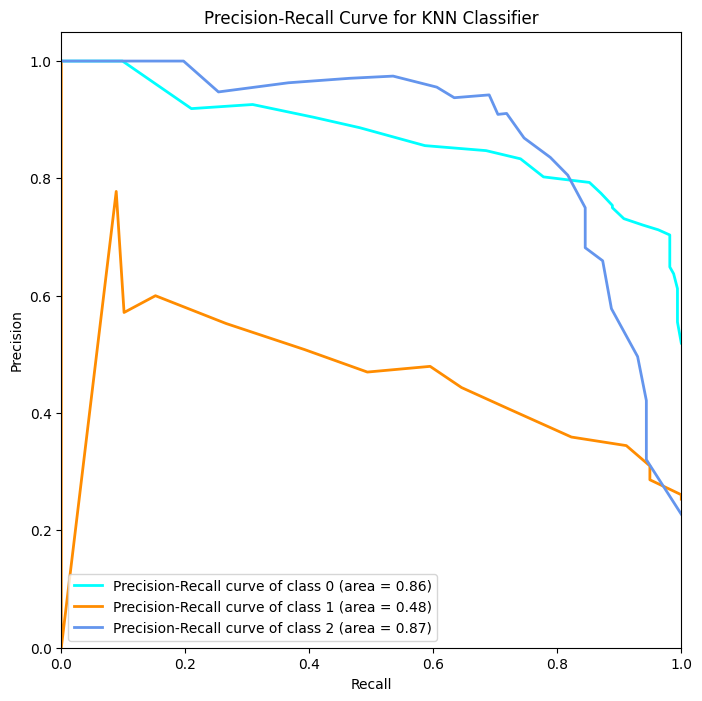

In [ ]:
# Compute Precision-Recall and plot curve
precision_knn = dict()
recall_knn = dict()
average_precision_knn = dict()

class_labels = ['mild', 'moderate', 'severe']

for i in range(n_classes):
    precision_knn[i], recall_knn[i], _ = precision_recall_curve(y_bin[:, i], y_pred_prob_knn[:, i])
    average_precision_knn[i] = average_precision_score(y_bin[:, i], y_pred_prob_knn[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(8, 8))

for i, color in zip(range(n_classes), colors):
    plt.plot(recall_knn[i], precision_knn[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision_knn[i]))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNN Classifier')
plt.legend(loc="lower left")
plt.show()


Both the severe and mild classes have the same AUPRC, which indicates a high precision and recall, at 0.87 and 0.86 respectively. Similar to L1 Logistic regression, the moderate class is fairly low, at 0.48.

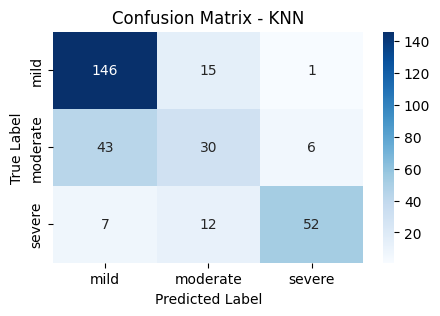

In [ ]:
conf_matrix = confusion_matrix(y_test, test_pred_knn)
class_labels = ['mild', 'moderate', 'severe']

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - KNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Most of the mild cases are correctly classified at 146 true positives 30 were correctly classified as moderate, and 52 were correctly labeled as severe.

## Random Forest Classifier

In [ ]:
# initialize the RandomForestClassifier with the optimal parameters
rf_optimal = RandomForestClassifier(
    criterion='gini',
    max_depth=7,
    max_features='sqrt',
    min_samples_leaf=1,
    n_estimators=500,
    random_state=42

)

# fit the model on the training set
rf_optimal.fit(X_train, y_train)

# predictions on the test set
y_pred = rf_optimal.predict(X_test)
y_proba = rf_optimal.predict_proba(X_test)

# print test accuracy and a classification report
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# get classification report in dictionary form
report_dict = classification_report(y_test, y_pred, output_dict=True)

# extract weighted average values from the classification report
precision_weighted_avg = report_dict['weighted avg']['precision']
recall_weighted_avg = report_dict['weighted avg']['recall']
f1_weighted_avg = report_dict['weighted avg']['f1-score']

# since RandomForest doesn't automatically output the best iteration, consider the total number of trees as the equivalent
best_iteration = rf_optimal.n_estimators

# combine all metrics into a single DataFrame for easy comparison
rf_metrics_df = pd.DataFrame({
    "Classifier": ["Random Forest"],
    "Best Iteration": [best_iteration],
    "Accuracy": [test_accuracy],
    "Precision": [precision_weighted_avg],
    "Recall": [recall_weighted_avg],
    "F1 Score": [f1_weighted_avg]
})
rf_metrics_df

Test Accuracy: 0.7532051282051282


,Classifier,Best Iteration,Accuracy,Precision,Recall,F1 Score
0,Random Forest,500,0.753205,0.748683,0.753205,0.743414


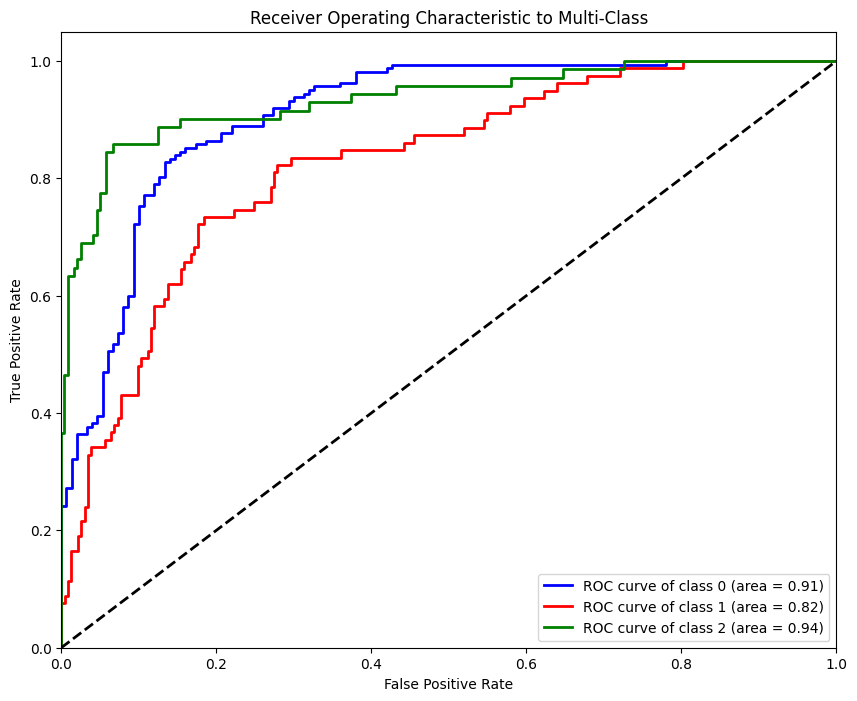

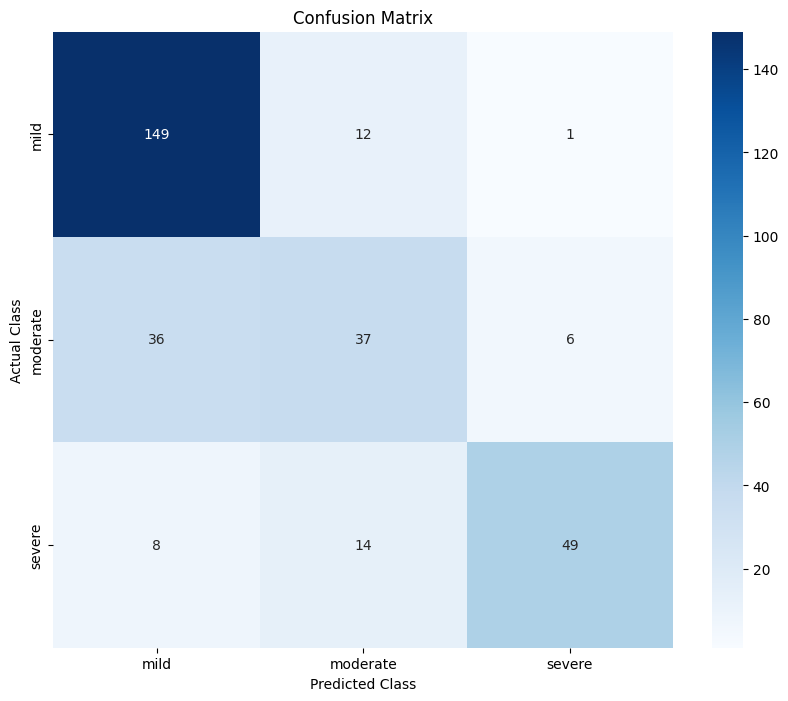

In [ ]:
# prepare for ROC Curve plotting for multi-class
classes = np.unique(y_train)  # Ensure y_train contains all possible labels
y_test_bin = label_binarize(y_test, classes=classes)

# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting all ROC curves
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()

class_names = le.classes_  # this retrieves the class names directly from the encoder

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=le.transform(class_names))

# plot the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



This Random Forest model performs very well in distinguishing between class 2 and other classes, quite well for class 0, and reasonably well for class 1. The differences in AUC might suggest varying degrees of separability in the feature space for each class, or it could reflect differences in the distribution or quantity of training data for each class. A higher AUC value generally indicate that the model is effective at ranking positive instances more highly than negative ones with high confidence across varied threshold settings. Resampling and tuning did not improve the performance of the model.



## Support Vector Machines (SVM)

In [ ]:
# Setup repeated cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

# Setup parameter grid for tuning
param_grid = {
    'classifier__C': np.logspace(-3, 3, 4),
    'classifier__gamma': np.logspace(-3, 3, 4),
}

# Setup the SVC classifier with radial basis function kernel
svm_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', SVC(kernel='rbf', probability=True, random_state=0))])

# Setup GridSearchCV for hyperparameter tuning and model selection
search = GridSearchCV(svm_classifier, param_grid, scoring='accuracy', cv=cv, verbose=1)

# Fit the model
svm_fit = search.fit(X_train, y_train)

# Best model parameters and score
print("Best parameters:", svm_fit.best_params_)
print("Best cross-validation accuracy:", svm_fit.best_score_)

# Access the best estimator
best_model = svm_fit.best_estimator_

# Best parameters: {'classifier__C': 1000.0, 'classifier__gamma': 0.001}
# Best cross-validation accuracy: 0.7324771689497716

Fitting 50 folds for each of 16 candidates, totalling 800 fits
Best parameters: {'classifier__C': 1000.0, 'classifier__gamma': 0.001}
Best cross-validation accuracy: 0.7324771689497716


An SVM classifier with a radial basis function (RBF) kernel was trained using GridSearchCV for hyperparameter tuning. The grid search evaluated different combinations of the cost parameter (C) and the gamma parameter (gamma) that controls the influence of training points. The best performing model was achieved with a cost of 1000 and a gamma of 0.001. This model achieved a cross-validation accuracy of 73.25%.

In [ ]:
# Obtain predictions for the SVM model
y_test_pred_svm = best_model.predict(X_test)

# Compute metrics for SVM model
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_test_pred_svm, average='weighted', zero_division=0)

# Combine all metrics into a single DataFrame for easy comparison
svm_metrics_df = pd.DataFrame({
    "Classifier": ["SVM"],
    "Accuracy": [accuracy_svm],
    "Precision": [precision_svm],
    "Recall": [recall_svm],
    "F1 Score": [f1_svm]
})
svm_metrics_df


,Classifier,Accuracy,Precision,Recall,F1 Score
0,SVM,0.721154,0.717375,0.721154,0.710765


The evaluation metrics for the SVM model with the best hyperparameters indicate a moderate performance on unseen test data. The model achieved an accuracy of 72.1%. However, we see a slight imbalance between precision (0.717) and recall (0.721). This indicates the model might be slightly better at predicting true positives (precision) but might miss some true positives at the cost of fewer false positives (recall).

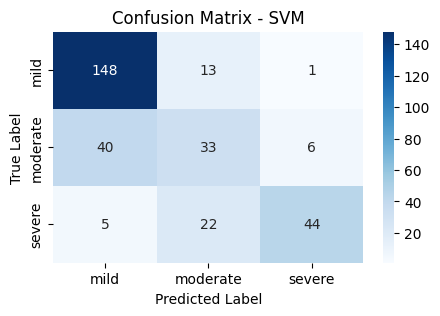

In [ ]:
# Make predictions on the test set
test_pred_svm = best_model.predict(X_test)

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, test_pred_svm)
class_labels = ['mild', 'moderate', 'severe']

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


The confusion matrix for the SVM classifier displays how the model performed in classifying instances into three categories: mild, moderate, and severe. These results indicate that the model is best at identifying 'mild' cases, followed by 'severe', and struggles the most with 'moderate' cases.

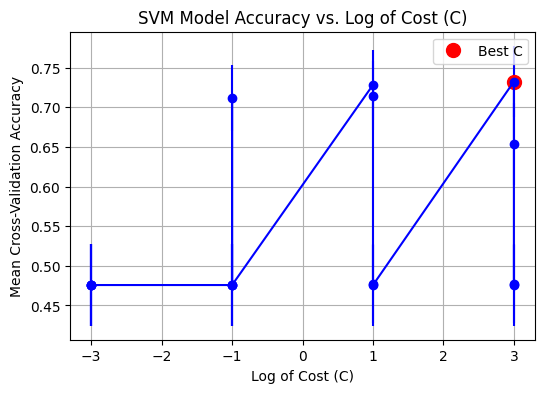

In [ ]:
# Plotting the accuracy of the best SVM model against the cost parameter (C)
mean_scores = np.array(svm_fit.cv_results_['mean_test_score'])
std_scores = np.array(svm_fit.cv_results_['std_test_score']) # Standard deviation of test scores
c_values = np.array(svm_fit.cv_results_['param_classifier__C'].data, dtype=float)

# Sort the scores and C values for a cleaner plot
sorted_indices = np.argsort(c_values)
c_values = c_values[sorted_indices]
mean_scores = mean_scores[sorted_indices]
std_scores = std_scores[sorted_indices]

log_c_values = np.log10(c_values)

plt.figure(figsize=(6, 4))
plt.errorbar(log_c_values, mean_scores, yerr=std_scores, marker='o', linestyle='-', color='b')
plt.title('SVM Model Accuracy vs. Log of Cost (C)')
plt.xlabel('Log of Cost (C)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.grid(True)

# Highlight the point with the best C value
best_log_c = np.log10(svm_fit.best_params_['classifier__C'])
best_score = svm_fit.best_score_
best_index = np.where(c_values == svm_fit.best_params_['classifier__C'])[0][0]  # Find the index of the best C value

plt.plot(best_log_c, best_score, marker='o', markersize=10, linestyle='', color='red', label='Best C')
plt.legend()

plt.show()


This plot represents the relationship between the accuracy of the SVM model and the log-transformed cost parameter (C). The graph indicates that as the log value of C increases, there is a non-linear relationship with the model's mean cross-validation accuracy. The point highlighted in red represents the 'best' C value according to the model selection process, which corresponds to the maximum mean cross-validation accuracy obtained. This point suggests that the optimal complexity of the model is found at this cost parameter, where the model balances well between bias and variance, maximizing the predictive accuracy on unseen data.


## XGBoost Classifier

In [ ]:
#XGBOOST
#optionally re-prepare data because previous cells' steps may have affected the encoding
label_encoder = LabelEncoder()
data['Severity_encoded'] = label_encoder.fit_transform(data['Severity'])  # encode severity labels numerically

# print the mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# define features and target
X = data.drop(columns=['Severity', 'Severity_encoded'])  # drop non-encoded target and other non-feature columns if present
y = data['Severity_encoded']  # Use the encoded target variable

classes = np.unique(y_train)  # capture all our unique classes
y_test_bin = label_binarize(y_test, classes=classes)

# splitting the full dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Label mapping: {'mild': 0, 'moderate': 1, 'severe': 2}


In [ ]:
classes = np.unique(y_train)  # this Captures our unique classes, in case previous cell isn't run
y_test_bin = label_binarize(y_test, classes=classes) # define the XGBoost model with fixed hyperparameters
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric='mlogloss', enable_categorical=True,
    n_estimators=100, max_depth=4, learning_rate=0.05, subsample=0.6, min_sample_leaf = 2,
    colsample_bytree=0.6, reg_lambda=0.5, alpha=0, gamma=0.1, min_child_weight=2
)

# train the model on the training set
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=3)



[0]	validation_0-mlogloss:1.06675	validation_1-mlogloss:1.07100
[3]	validation_0-mlogloss:0.99769	validation_1-mlogloss:1.00954
[6]	validation_0-mlogloss:0.93196	validation_1-mlogloss:0.94975
[9]	validation_0-mlogloss:0.87458	validation_1-mlogloss:0.89675
[12]	validation_0-mlogloss:0.82381	validation_1-mlogloss:0.85252
[15]	validation_0-mlogloss:0.78072	validation_1-mlogloss:0.81471
[18]	validation_0-mlogloss:0.74321	validation_1-mlogloss:0.78247
[21]	validation_0-mlogloss:0.71204	validation_1-mlogloss:0.75670
[24]	validation_0-mlogloss:0.68464	validation_1-mlogloss:0.73263
[27]	validation_0-mlogloss:0.65946	validation_1-mlogloss:0.71370
[30]	validation_0-mlogloss:0.63640	validation_1-mlogloss:0.69689
[33]	validation_0-mlogloss:0.61698	validation_1-mlogloss:0.68179
[36]	validation_0-mlogloss:0.60134	validation_1-mlogloss:0.67118
[39]	validation_0-mlogloss:0.58447	validation_1-mlogloss:0.65884
[42]	validation_0-mlogloss:0.56958	validation_1-mlogloss:0.64828
[45]	validation_0-mlogloss:0.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:36:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_sample_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[75]	validation_0-mlogloss:0.46082	validation_1-mlogloss:0.59181
[78]	validation_0-mlogloss:0.45399	validation_1-mlogloss:0.59079
[81]	validation_0-mlogloss:0.44743	validation_1-mlogloss:0.58878
[84]	validation_0-mlogloss:0.44216	validation_1-mlogloss:0.58695
[87]	validation_0-mlogloss:0.43711	validation_1-mlogloss:0.58523
[90]	validation_0-mlogloss:0.43135	validation_1-mlogloss:0.58262
[93]	validation_0-mlogloss:0.42642	validation_1-mlogloss:0.58114
[96]	validation_0-mlogloss:0.42135	validation_1-mlogloss:0.57961
[99]	validation_0-mlogloss:0.41648	validation_1-mlogloss:0.57792


XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=2, min_sample_leaf=2,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=100, n_jobs=None, ...)

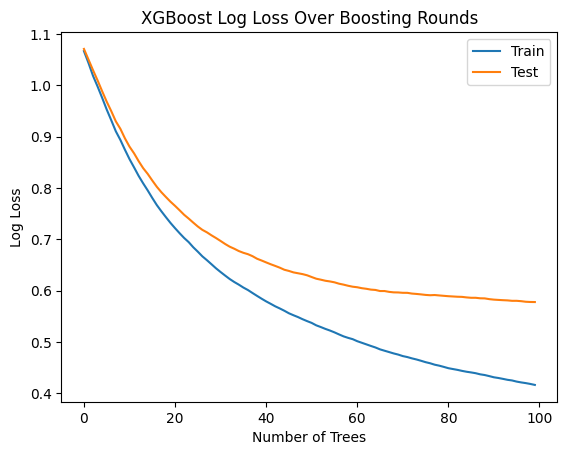

Test Accuracy: 0.7788461538461539


,Classifier,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.778846,0.773914,0.778846,0.766424


In [ ]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot the log loss over boosting rounds
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Boosting Rounds')
plt.xlabel('Number of Trees')
plt.show()

# Print test accuracy and a classification report
y_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# Get classification report in dictionary form
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Calculate the weighted average values which take into account the imbalance in the classes
precision_weighted_avg = report_dict['weighted avg']['precision']
recall_weighted_avg = report_dict['weighted avg']['recall']
f1_weighted_avg = report_dict['weighted avg']['f1-score']


# Combine all metrics into a single DataFrame for easy comparison
xgb_metrics_df = pd.DataFrame({
    "Classifier": ["XGBoost"],
    "Accuracy": [test_accuracy],
    "Precision": [precision_weighted_avg],
    "Recall": [recall_weighted_avg],
    "F1 Score": [f1_weighted_avg]
})
xgb_metrics_df



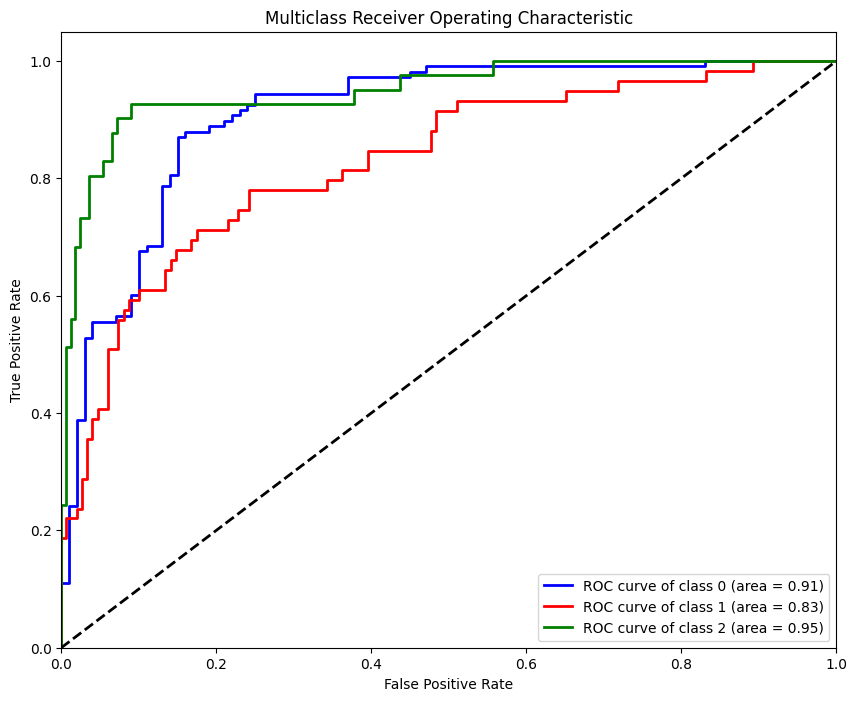

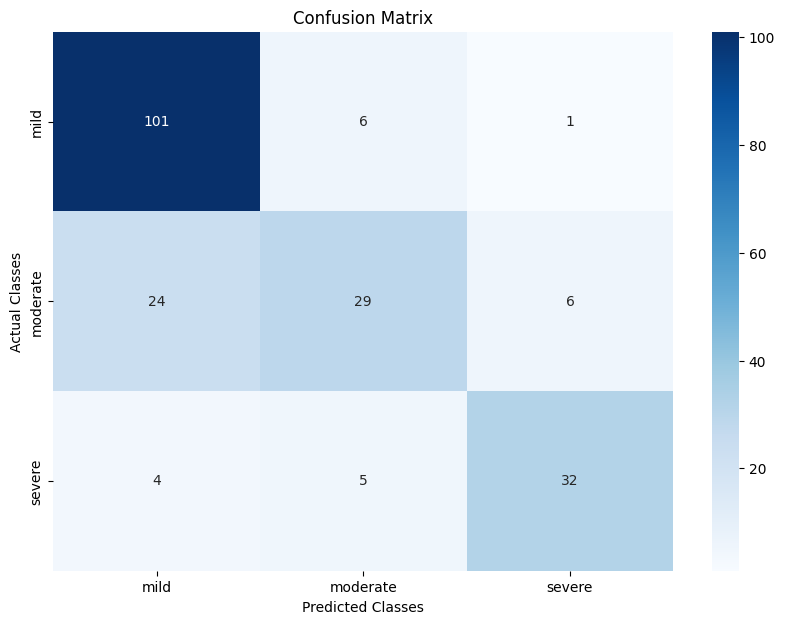

In [ ]:
# prepare for ROC Curve plotting
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_proba = xgb_model.predict_proba(X_test)

# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot all ROC curves
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_  # class names as a list of categories

# plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

The loss curve shows that the model stops improving at approximately 100 boosting rounds, which tells us the training should be stopped here to prevent overfitting. The confusion matrix tells us that the biggest problem our model is encountering is prioritizing high confidence in positive predictions, at the expense of missing some true positives. The ROC Curve tells us the same story.

This is likely due to the small dataset, and, as mentioned previously, class imbalance. We tested upsampling and other methods, but the results did not improve. With a test accuracy of 0.778, XGBoost is the model which performed the best.

## SGD Classifier

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],  # Proportion of the training data to use for each iteration
    'min_samples_split': [2, 3, 4]  # Minimum number of samples required to split an internal node
}

# Create a GradientBoostingClassifier object
gbm = GradientBoostingClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Execute the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score found
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.7}


In [ ]:

# Define the GradientBoostingClassifier with the best parameters from grid search
optimal_gbm = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    subsample=0.7,
    n_estimators=100,
    random_state=42
)

# Fit the model on the entire training set using these parameters
optimal_gbm.fit(X_train, y_train)

# Predict on the test set
y_pred = optimal_gbm.predict(X_test)

# Output the test accuracy and classification report
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, output_dict=True)

# Extract weighted average values from the classification report
precision_weighted_avg = class_report['weighted avg']['precision']
recall_weighted_avg = class_report['weighted avg']['recall']
f1_weighted_avg = class_report['weighted avg']['f1-score']

# Since GradientBoostingClassifier doesn't output the best iteration, we use the total number of estimators
best_iteration = optimal_gbm.n_estimators

# Combine all metrics into a single DataFrame for easy comparison
gbm_metrics_df = pd.DataFrame({
    "Classifier": ["SGD Boosting"],
    "Best Iteration": [best_iteration],
    "Accuracy": [test_accuracy],
    "Precision": [precision_weighted_avg],
    "Recall": [recall_weighted_avg],
    "F1 Score": [f1_weighted_avg]
})


gbm_metrics_df



Test accuracy: 0.7596153846153846

Classification Report:


,Classifier,Best Iteration,Accuracy,Precision,Recall,F1 Score
0,SGD Boosting,100,0.759615,0.754297,0.759615,0.75616


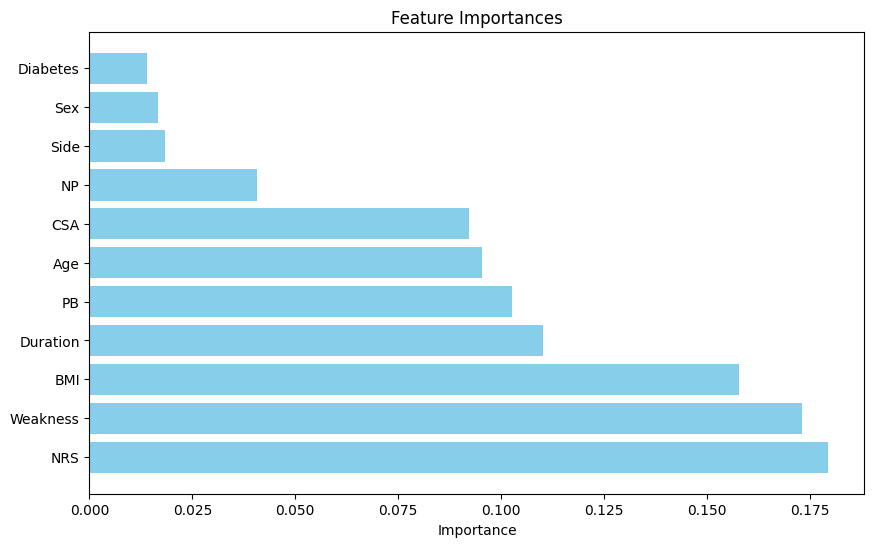

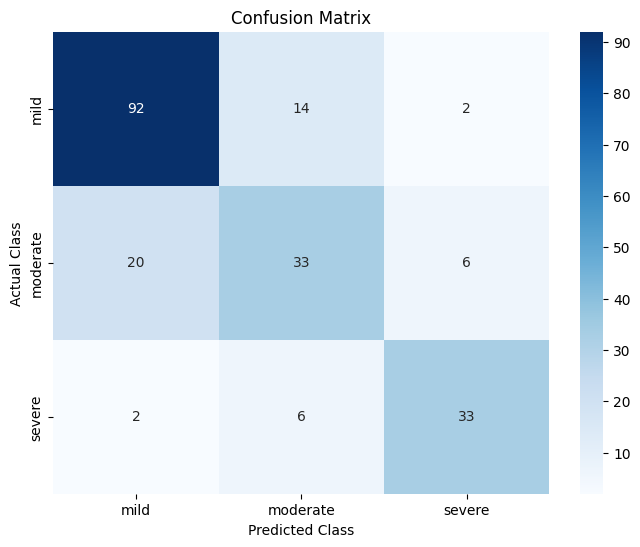

In [ ]:
# Display feature importances
feature_importances = optimal_gbm.feature_importances_
features = pd.DataFrame(list(zip(X.columns, feature_importances)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(features['Feature'], features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



As we can see, the most important features are Weakness, NRS, and Duration. The Test Accuracy of 0.7502 indicates a robust model, and the confusion matrix follows a similar pattern to our other models. The largest factor impacting the similarities between models is the imbalanced and relatively small dataset. Resampling and SMOTE did not help the results.

## Neural Network Classifier

In [ ]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert labels to categorical one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Define the model with regularization and dropout
input_shape = X_train_transformed.shape[1]
nn_classifier = Sequential()
nn_classifier.add(Dense(10, input_shape=(input_shape,), activation='relu', kernel_regularizer=l2(0.01)))
nn_classifier.add(Dropout(0.5))
nn_classifier.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
nn_classifier.add(Dropout(0.5))
nn_classifier.add(Dense(3, activation='softmax'))  # Output layer: 3 neurons for 3 classes

# Compile the model
nn_classifier.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy',  tf.keras.metrics.Precision(name='val_precision'), tf.keras.metrics.Recall(name='val_recall')])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Create a History object for callbacks to store the loss and accuracy
history = History()

# Train the model with validation data
nn_classifier.fit(X_train_transformed, y_train_one_hot,
          epochs=100,
          batch_size=5,
          verbose=1,
          validation_data=(X_test_transformed, y_test_one_hot),
          callbacks=[history, early_stopping])

nn_classifier.summary()

Epoch 1/100
166/166 [==============================] - 5s 7ms/step - loss: 1.4378 - accuracy: 0.3884 - val_precision: 0.4103 - val_recall: 0.1544 - val_loss: 1.2430 - val_accuracy: 0.4519 - val_val_precision: 0.6316 - val_val_recall: 0.0577
Epoch 2/100
166/166 [==============================] - 1s 7ms/step - loss: 1.2750 - accuracy: 0.4560 - val_precision: 0.5081 - val_recall: 0.1508 - val_loss: 1.1438 - val_accuracy: 0.5769 - val_val_precision: 0.8125 - val_val_recall: 0.1875
Epoch 3/100
166/166 [==============================] - 1s 8ms/step - loss: 1.1942 - accuracy: 0.4765 - val_precision: 0.6217 - val_recall: 0.1725 - val_loss: 1.0902 - val_accuracy: 0.5865 - val_val_precision: 0.8030 - val_val_recall: 0.2548
Epoch 4/100
166/166 [==============================] - 1s 5ms/step - loss: 1.1343 - accuracy: 0.5115 - val_precision: 0.6717 - val_recall: 0.2147 - val_loss: 1.0390 - val_accuracy: 0.6202 - val_val_precision: 0.8375 - val_val_recall: 0.3221
Epoch 5/100
166/166 [===============

**Model Architecture:**

Through experimentation, we arrived at a compact model architecture with 2 hidden layers, each containing 10 neurons. While we explored models with additional layers and more neurons per layer, these configurations resulted in rapid overfitting.

ReLU activation functions were used in the hidden layers to introduce non-linearity and improve model capacity for learning complex relationships in the data. A Softmax activation function was used in the output layer to generate class probabilities that sum to 1. This is suitable for multi-class classification tasks.

To address overfitting and promote generalization, L2 regularization with a coefficient of 0.01 was employed. This technique penalizes large weights in the model, discouraging the model from relying heavily on a small subset of features. We also incorporated dropout layers with a dropout rate of 50%, forcing the model to learn robust features that are not dependent on specific neurons. This helps the model perform better on unseen data.

In [ ]:
# Compute metrics for NN model
val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

# Assuming you want the best epoch according to validation loss
best_epoch = np.argmin(history.history['val_loss'])

# Calculate F1-score from precision and recall
val_f1_score = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(val_precision, val_recall)]

# Combine all metrics into a single DataFrame for easy comparison
nn_metrics_df = pd.DataFrame({
    "Classifier": ["Neural Network"],
    "Best Epoch": [best_epoch + 1],  # Epochs are zero-indexed, but we refer to epochs starting from 1
    "Accuracy": [val_accuracy[best_epoch]],
    "Precision": [val_precision[best_epoch]],
    "Recall": [val_recall[best_epoch]],
    "F1 Score": [val_f1_score[best_epoch]]
})
nn_metrics_df

,Classifier,Best Epoch,Accuracy,Precision,Recall,F1 Score
0,Neural Network,49,0.745192,0.763934,0.562123,0.647672


7/7 [==============================] - 0s 2ms/step


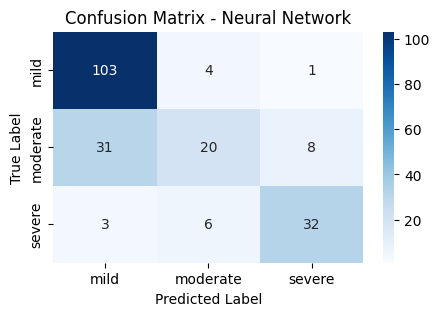

In [ ]:
# Predict probabilities for the test set
test_probabilities = nn_classifier.predict(X_test_transformed)

# Convert probabilities to class labels
test_pred_labels = np.argmax(test_probabilities, axis=1)

# Convert one-hot encoded test labels back to class labels for comparison
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Compute the confusion matrix
conf_matrix_nn = confusion_matrix(y_test_labels, test_pred_labels)
class_labels = ['mild', 'moderate', 'severe']

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Model Performance**

The network exhibits high accuracy but demonstrates uneven performance across different metrics. The high precision but lower recall suggests a conservative approach to predicting positive classes. This implies the model prioritizes high confidence in positive predictions, potentially at the expense of missing some true positives.

This behavior could be due to class imbalance. When the model encounters classes with significantly different representation in the data, it might learn to favor the more frequent class, neglecting the underrepresented ones. We tested the SMOTE technique for balanced sampling, but it did not improve the results.

The data distribution or structure itself could also be contributing to the difficulty. Overlapping or similar feature distributions between classes can make it challenging for the model to distinguish them. Outliers might further exacerbate this issue.

Possible solutions include additional feature engineering to create features that better differentiate between classes, or incorporating more complex model architectures that might be better suited to handle these challenges.


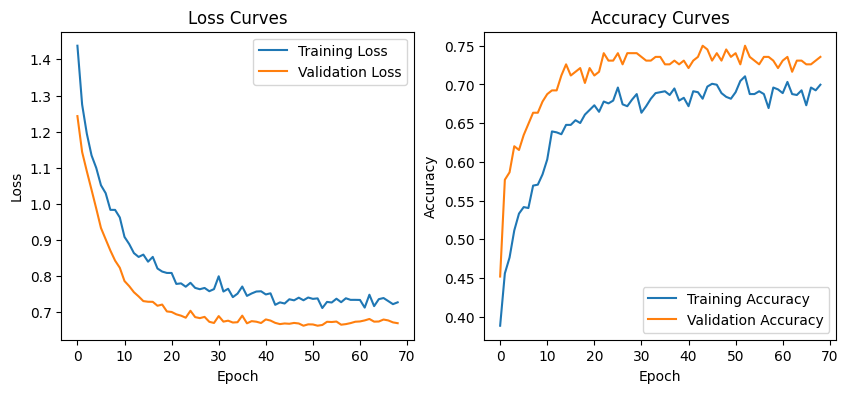

In [ ]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(10, 4))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


The training loss decreases sharply at the beginning and then continues to decline at a slower pace, which indicates that the model is learning from the data. The validation loss mirrors the training loss closely throughout the training process, which suggests good generalization and no clear sign of overfitting.

Both the training and validation accuracy improve rapidly in the early epochs, which is common as the model begins to learn from the training data.
The training accuracy continues to increase and eventually plateaus, indicating that the model might have reached its learning capacity given the current architecture and dataset. The validation accuracy follows the training accuracy quite closely, although it's slightly lower. This again indicates that the model is generalizing well to the validation set.

## Evaluation
Evaluate the models using the test set:

In [ ]:
combined_metrics_df = pd.concat([
    l1_metrics_df,
    knn_metrics_df,
    rf_metrics_df,
    svm_metrics_df,
    xgb_metrics_df,
    gbm_metrics_df,
    nn_metrics_df
], ignore_index=True)

# Display the combined DataFrame
combined_metrics_df


,Classifier,Accuracy,Precision,Recall,F1 Score,Best Iteration,Best Epoch
0,L1 Logistic Regression,0.730769,0.725818,0.730769,0.722968,NaN,NaN
1,KNN Classifier,0.730769,0.720605,0.730769,0.717266,NaN,NaN
2,Random Forest,0.753205,0.748683,0.753205,0.743414,500.0,NaN
3,SVM,0.721154,0.717375,0.721154,0.710765,NaN,NaN
4,XGBoost,0.778846,0.773914,0.778846,0.766424,NaN,NaN
5,SGD Boosting,0.759615,0.754297,0.759615,0.756160,100.0,NaN
6,Neural Network,0.745192,0.763934,0.562123,0.647672,NaN,49.0


In [ ]:
top3_accuracy = combined_metrics_df.nlargest(3, 'Accuracy')
top3_f1_score = combined_metrics_df.nlargest(3, 'F1 Score')

print("Top 3 Models by Accuracy:")
print(top3_accuracy[['Classifier', 'Accuracy']])

print("\nTop 3 Models by F1 Score:")
print(top3_f1_score[['Classifier', 'F1 Score']])

Top 3 Models by Accuracy:
      Classifier  Accuracy
4        XGBoost  0.778846
5   SGD Boosting  0.759615
2  Random Forest  0.753205

Top 3 Models by F1 Score:
      Classifier  F1 Score
4        XGBoost  0.766424
5   SGD Boosting  0.756160
2  Random Forest  0.743414


The results from our models suggest that the top 3 most performant models are XGBoost, SGD Boosting, and Random Forest. However, we suggest using XGBoost for its performance with an accuracy of 0.778846 and an F1 Score of 0.743414.

## Limitations and Future Scope


1) **Look for data that includes follow-up on patients.** The severity of CTS can change over time and having long-term follow up data can provide insight via time-series analyses. Trend analysis offers insight into variables that may worsen the severity of CTS. Time-series data also gives us the opportunity for forecasting the severity of CTS and whether they may improve or worsen.

2) **Look for data with more environmental features.** All of the features were either biological or physiological variables. Other helpful features that could be used for model building include job type, amount of time spent typing at work, amount of physical activity, investments into ergonomic pratices at work. These will all help better classify the severity of CTS.

3) **Data was only collected at a single site.** Sampling bias may play a factor as the retrospective collection meaning the data was not collected with analysis in mind. The authors of the dataset also stated how there may be inter-clinician bias in how data were collected since there would have been multiple clinicians overseeing the many patients. Future steps could be to look for data with multi-center studies or introduce robust sampling techniques such as random sampling or stratified sampling.

4) **Work closely with subject matter experts.** We suspect that the models can be improved if we were able to handle outliers with guidance from subject matter experts. They can interpret outliers and examine whether they are true outliers or measurement errors. They can also examine whether to remove or leave outliers. Additionally, they would be able to verify if the distribution of severity in the dataset was reasonable.

## Conclusion

Our main objective for the project was to develop a model that best classifies the severity of CTS based on clinical and sonographic data. Based on our EDA, there were no concerning multicollinearity between the features and no non-zero variances that initially suggest removal of features. Our dataset had a few outliers, but we acknowledge that we do not have enough domain knowledge to decide on removing them and that these outliers may influence the performance of our models. We chose to develop 6 models, Logistic Regression, KNN, SVM, eXtreme Gradient Boosting, Stochastic Gradient Boosting, and Neural Network. Our L1 Logistic Regression can be used potential feature selection. a simpler model would consist of removing the sex feature. However, we kept all the features in our other models. Out of these 6 models, we found that eXtreme Gradient Boosting was the most performant out of all the models we developed, with an F1 score of 0.773918 and an accuracy of 0.778846 . Thus, we recommend fine-tuning eXtreme Gradient Boosting models when attempting to classify the severity of CTS based on the dataset collected by Park et al. (2021).

## References
Park, D., Kim, B. H., Lee, S.-E., Kim, D. Y., Kim, M., Kwon, H. D., Kim, M.-C., Kim, A. R., Kim, H. S., & Lee, J. W. (2021). Machine learning-based approach for disease severity classification of carpal tunnel syndrome. Scientific Reports, 11, 17464. https://doi.org/10.1038/s41598-021-97043-7
